<a href="https://colab.research.google.com/github/DipeshChothwe/NLP/blob/master/Sentiment_analysis_for_hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Understanding our data**

In [7]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [9]:
test_data.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [16]:
print("length of train data: ", len(train_data))
print("length of test data: ", len(test_data))
print("missing values from train dataset columns:")
print(train_data.isnull().sum())
print("missing values from test dataset columns:")
test_data.isnull().sum()

length of train data:  38932
length of test data:  29404
missing values from train dataset columns:
User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64
missing values from test dataset columns:


User_ID         0
Description     0
Browser_Used    0
Device_Used     0
dtype: int64

In [27]:
print("Unique labels in colummn: Browser_Used",train_data['Browser_Used'].unique())
print("")
print("Number of unique labels in column: Browser_Used", len(train_data['Browser_Used'].unique()))


Unique labels in colummn: Browser_Used ['Edge' 'Internet Explorer' 'Mozilla' 'InternetExplorer' 'Firefox'
 'Google Chrome' 'Chrome' 'IE' 'Opera' 'Mozilla Firefox' 'Safari']

Number of unique labels in column: Browser_Used 11


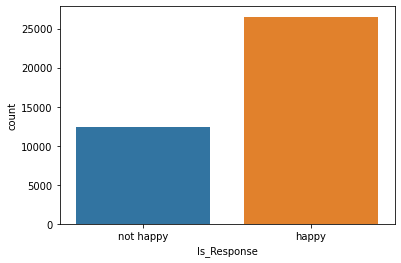

In [52]:
sns.countplot(train_data['Is_Response'])

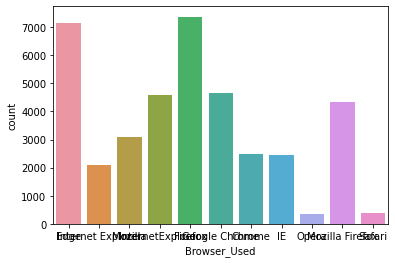

In [51]:
sns.countplot(train_data['Browser_Used'])


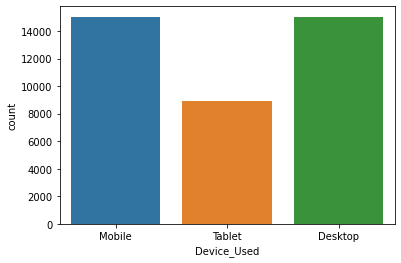

In [38]:
sns.countplot(train_data['Device_Used'])

In [39]:
x = train_data
x = x.groupby('Is_Response')
x.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy
5,id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,happy
6,id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,not happy
7,id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,happy
8,id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,happy
10,id10336,"Steps off Times Square, nice rooms, stayed - n...",Internet Explorer,Tablet,happy




*   Our data does not have null entries
*   Data has more than two times good reviews than bad reviews



# **Data preprocessing**

In [46]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [53]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove tokens that are less than length 2
    text = [t for t in text if len(t) > 1]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
train_data["Description"] = train_data["Description"].apply(lambda x: clean_text(x))


In [54]:
# add number of characters column
train_data["nb_chars"] = train_data["Description"].apply(lambda x: len(x))

# add number of words column
train_data["nb_words"] = train_data["Description"].apply(lambda x: len(x.split(" ")))

In [55]:
train_data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,nb_chars,nb_words
0,id10326,room kind clean strong smell dog generally ave...,Edge,Mobile,not happy,134,21
1,id10327,stay crown plaza april april staff friendly at...,Internet Explorer,Mobile,not happy,621,98
2,id10328,booked hotel hotwire low price could find got ...,Mozilla,Tablet,not happy,776,116
3,id10329,stayed husband son way alaska cruise love hote...,InternetExplorer,Desktop,happy,320,51
4,id10330,girlfriend stay celebrate th birthday plan wee...,Edge,Tablet,not happy,907,134
